<a href="https://colab.research.google.com/github/NasraDiriye/Flight-departure-delay-prediction/blob/main/BAY_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bayensian Inference

### Title: Predicting flight delays at PIT airport

### Name: Nasra Diriye


# Abstract
This project aims to predict the probability of a flight being delayed by more than 15 minutes based on feature such as Month, DayOfWeek, CRSDepTime, Origin, and Distance. A Bayesian logistic regression model is used to estimate how these features influence the likelihood of a delay. The model utilizes MCMC sampling to estimate the relationships between the predictors and the delay.

The data is first prepared by standardizing the features and splitting it into training and test sets. The results show that Origin and Distance have the greatest impact on the likelihood of a delay, while Month and DayOfWeek have a smaller effect.

This approach demonstrates the value of Bayesian methods in providing both predictions and uncertainty estimates, offering useful insights for airlines to improve operations and customer service.

# Introduction
The dataset for this project contains flight information to and from Pittsburgh International Airport (PIT) in 2006, extracted from the Bureau of Transportation Statistics. It includes details such as scheduled departure times, flight numbers, carriers, and weather-related information. The target variable is DepDelay (departure delay in minutes). The goal is to predict whether a flight will experience a significant delay (greater than 15 minutes). Airlines and passengers can benefit from this prediction by anticipating disruptions of their planned trips and adjusting schedules accordingly. The hypotheses is whether specific variables, such as 'Month', 'DayOfWeek', 'DepTime', 'CRSDepTime', 'Dest', 'Distance' have a statistically significant effect on the probability of a flight being delayed by more than 15 minutes

The code packages used in this project:

I will use Python for this project due to its extensive library support for data science and machine learning tasks.

    Data manipulation: pandas, numpy
    Model building & evaluation: sklearn, pymc
    Data visualization: matplotlib, seaborn, arviz
    Statistical functions: scipy.stats
    Preprocessing: sklearn.preprocessing

In [1]:

import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
#!pip install pymc
import pymc as pm
import scipy.stats as stats
from sklearn.preprocessing import LabelEncoder
import arviz as az
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import networkx as nx



## Methods

Summary of methods used:

Data processing:

    Data cleaning: pandas
    Standardization: StandardScaler
    Train-test split: train_test_split

Model Building:

    Bayesian linear regression: pymc
    Priors: normal distributions for coefficients and intercept
    Linear model formulation: mu = dot(X, coef) + intercept
    Likelihood function: Normal distribution for target variable with unknown error term.



Inference:

    MCMC sampling: pm.sample for posterior sampling
    Posterior analysis: arviz for visualizing posterior distributions and summarizing results.


### Dataset description and processing



List of the variables used from the PIT dataset:

Name | Type
------| :-----
Month | integer (nullable = true)
DayOfWeek | integer (nullable = true)
CRSDepTime | integer (nullable = true)
DepDelay | integer (nullable = true)
Origin | string (nullable = true)
Distance | integer (nullable = true)



Random Variables:.

        Variables like CRSDepTime, Origin and Distance are random. These variables are assumed to follow distributions based on historical data and are not controlled.

Deterministic Variables:

        Variables as Month and DayOfWeek are deterministic. They don’t vary randomly but influence other variables



1. Observed Variables:
features like Month, DayOfWeek, CRSDepTime,Origin,Distance.

2. Target variable:
DepDelay: Predict delay > 15 minutes

3. Unobserved factors as latent variables. These could be:


        Weather: bad weather could affect delays across multiple flights on a given day, but the PIT don't have this data.
        Air traffic control (ATC) issues: system-wide or regional ATC problems can cause delays, but are not directly in the PIT.




    Month  DayOfWeek  CRSDepTime Origin  Distance  DepDelay
2     1.0          3        1805    BOS       496      19.0
23    1.0          3        1545    LGA       335      28.0
31    1.0          3        1450    ORD       412      49.0
32    1.0          3        1000    ORD       412      21.0
33    1.0          3        1700    ORD       412      59.0
Month         float64
DayOfWeek       int64
CRSDepTime      int64
Origin         object
Distance        int64
DepDelay      float64
dtype: object


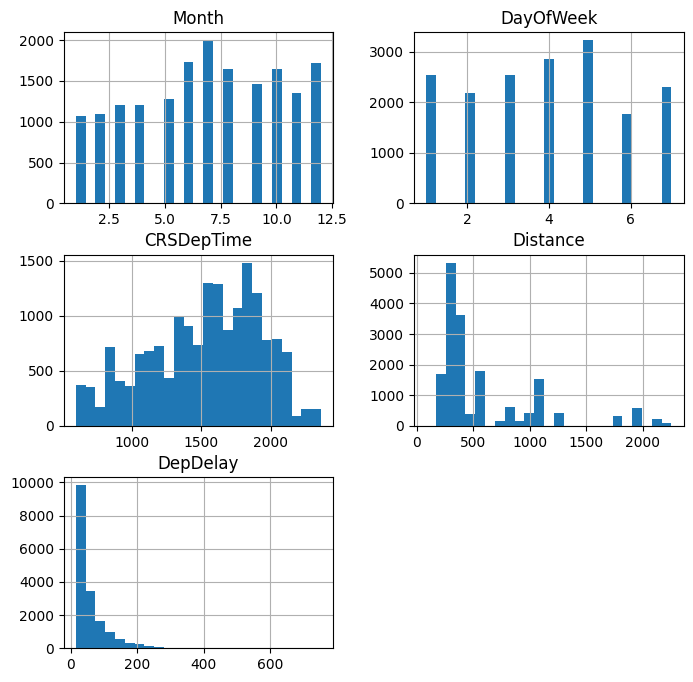

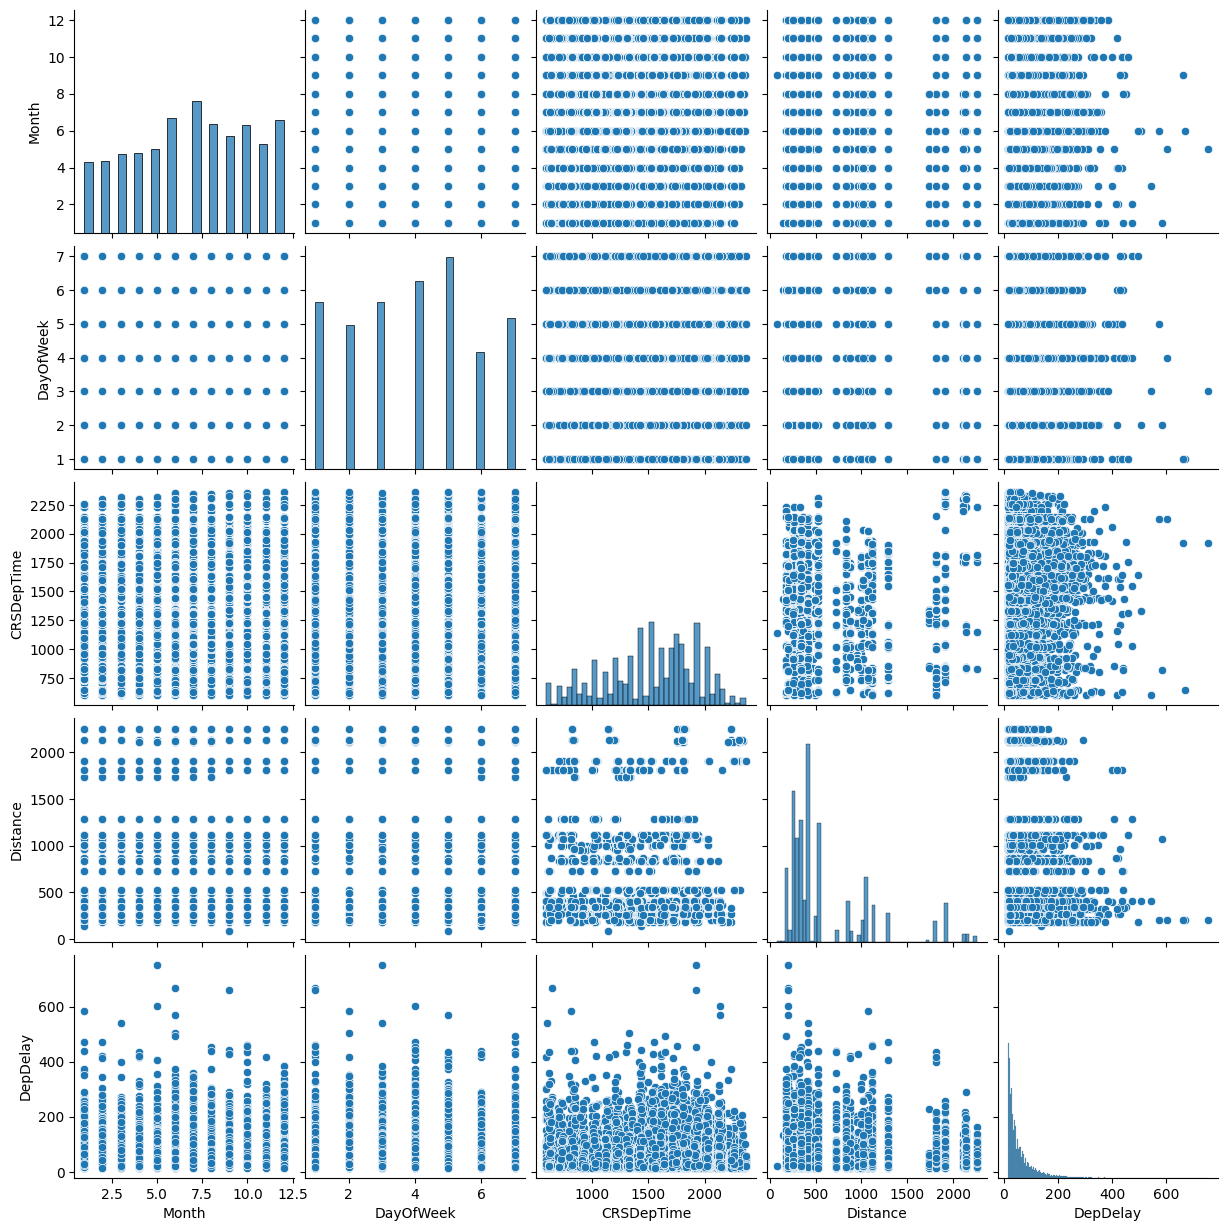

In [3]:
df=pd.read_csv("/content/all_PIT_2006 - all_PIT_2006.csv", sep=",")

variables = [
 'Month', 'DayOfWeek','CRSDepTime', 'Origin', 'Distance', 'DepDelay'
]

#Contains the variables that I need
filtered_df = df[variables]

# Deleys over 15 minutes
filtered_df = filtered_df[filtered_df['DepDelay'] > 15]

#departure time in hours


#remove all column that contain NaN values
filtered_df = filtered_df.dropna()

print(filtered_df.head())
print(filtered_df.dtypes)

_ = filtered_df.hist(figsize=(8, 8), bins=25)
_ = sns.pairplot(filtered_df)


   Origin  Origin_encoded
0     ATL               0
1     BDL               1
2     BOS               2
3     CKB               3
4     CLT               4
5     CVG               5
6     DCA               6
7     DEN               7
8     DFW               8
9     DTW               9
10    EWR              10
11    FLL              11
12    IAD              12
13    IAH              13
14    JFK              14
15    LAS              15
16    LAX              16
17    LGA              17
18    MCO              18
19    MDW              19
20    MIA              20
21    MSP              21
22    MYR              22
23    ORD              23
24    PBI              24
25    PHL              25
26    PHX              26
27    PIT              27
28    PVD              28
29    RSW              29
30    SAN              30
31    SEA              31
32    SFO              32
33    SJU              33
34    TPA              34


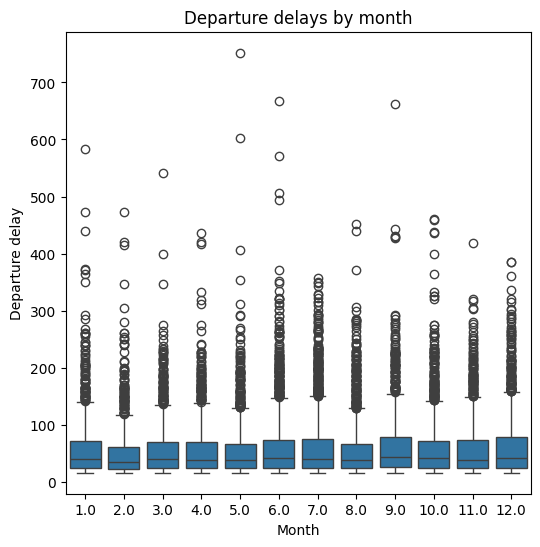

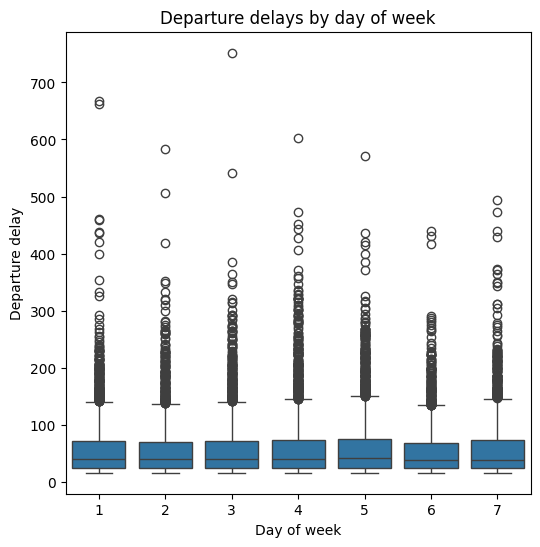

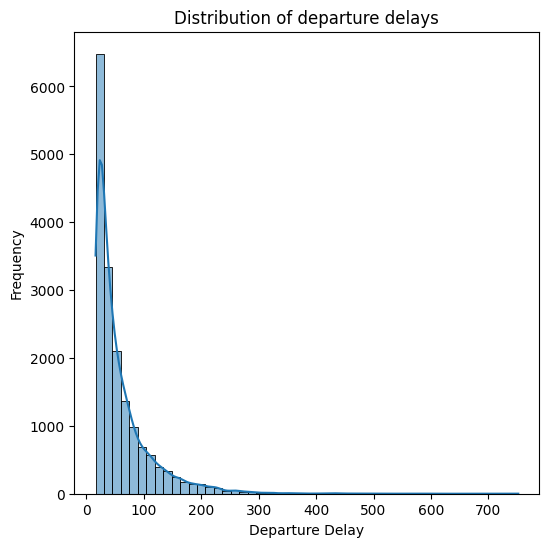

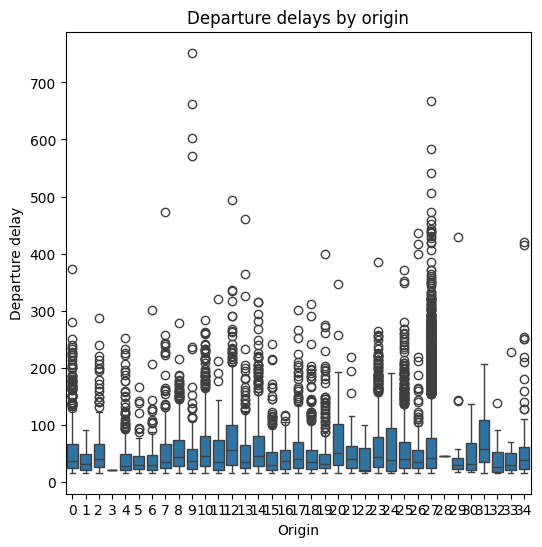

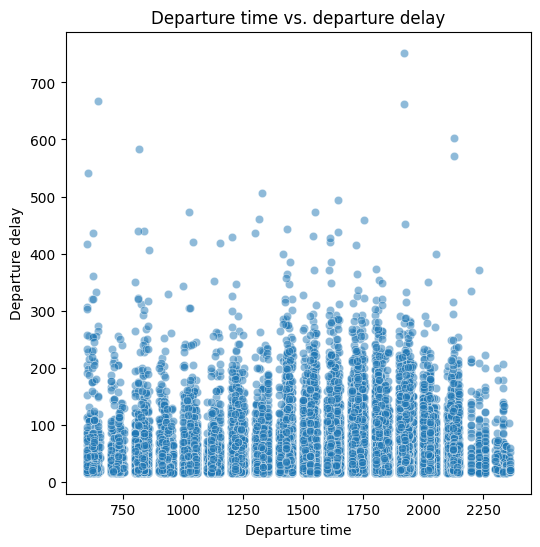

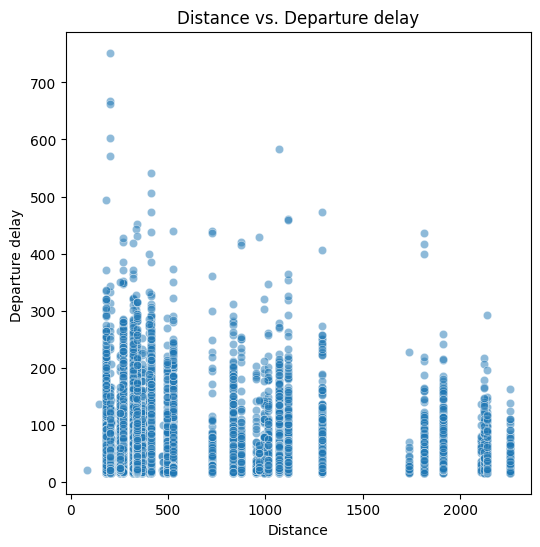

In [4]:
# plot the variable distribution with some preprocessing here to
# support your assumption and hypothesis,  but don't be
# restricted to this code, you should think about relevant way
# of explaining your own hypothesis

le = LabelEncoder()
filtered_df['Origin'] = le.fit_transform(filtered_df['Origin'])

mapping_df = pd.DataFrame({'Origin': le.classes_, 'Origin_encoded': le.transform(le.classes_)})

print(mapping_df)



#Boxplot of departure delays by month
plt.figure(figsize=(6, 6))
sns.boxplot(x='Month', y='DepDelay', data=filtered_df)
plt.title("Departure delays by month")
plt.xlabel("Month")
plt.ylabel("Departure delay")
plt.show()

#Boxplot of departure delays by day of week
plt.figure(figsize=(6, 6))
sns.boxplot(x='DayOfWeek', y='DepDelay', data=filtered_df)
plt.title("Departure delays by day of week")
plt.xlabel("Day of week")
plt.ylabel("Departure delay")
plt.show()

#Distribution of departure delays
plt.figure(figsize=(6, 6))
sns.histplot(filtered_df['DepDelay'], bins=50, kde=True)
plt.title("Distribution of departure delays")
plt.xlabel("Departure Delay")
plt.ylabel("Frequency")
plt.show()


#Boxplot of departure delays by encoded origin
plt.figure(figsize=(6, 6))
sns.boxplot(x='Origin', y='DepDelay', data=filtered_df)
plt.title("Departure delays by origin")
plt.xlabel("Origin")
plt.ylabel("Departure delay")
plt.show()

# Scatter plot of departure time vs. departure delay
plt.figure(figsize=(6, 6))
sns.scatterplot(x='CRSDepTime', y='DepDelay', data=filtered_df, alpha=0.5)
plt.title("Departure time vs. departure delay")
plt.xlabel("Departure time")
plt.ylabel("Departure delay")
plt.show()

#Scatter plot of distance vs. departure delay
plt.figure(figsize=(6, 6))
sns.scatterplot(x='Distance', y='DepDelay', data=filtered_df, alpha=0.5)
plt.title("Distance vs. Departure delay")
plt.xlabel("Distance")
plt.ylabel("Departure delay ")
plt.show()


### Model description

**Generative process:**


*   Month, DayOfWeek, CRSDepTime, Origin, Distance these are considered variables influencing the departure delay. They follow these distributions:


    1.Month,DayOfWeek: Categorical distributions, representing the probability of a flight occurring in a specific month or on a specific day of the week.
    2.CRSDepTime: A continuous distribution (normal or uniform) representing the scheduled departure time.
    3.Origin: A categorical distribution representing the origin airport.
    4.Distance: A continuous distribution (exponential or gamma) representing the flight distance.

*  DepDelay: this is the target variable, representing the departure delay. It is influenced by the variables mentioned above. It can be modeled using a distribution that is suitable for continuous (gamma or log-normal).


Pseude code for each flight:

1. For each flight:
        a. Sample Month from a categorical distribution.
        b. Sample DayOfWeek from a categorical distribution.
        c. Sample CRSDepTime from a continuous distribution (e.g., normal or uniform).
        d. Sample Origin from a categorical distribution.
        e. Sample Distance from a continuous distribution (e.g., exponential or gamma).
        f. Calculate DepDelay using a function that depends on Month, DayOfWeek, CRSDepTime, Origin, and Distance.

2. Store the generated data in a table with columns for Month, DayOfWeek, CRSDepTime, Origin, Distance, and DepDelay.

Joint probability:
P(Month, DayOfWeek, CRSDepTime, Origin, Distance, DepDelay) =
P(Month) * P(DayOfWeek) * P(Origin) * P(CRSDepTime|Origin) * P(Distance|Origin) * P(DepDelay | Month, DayOfWeek, CRSDepTime, Origin, Distance)



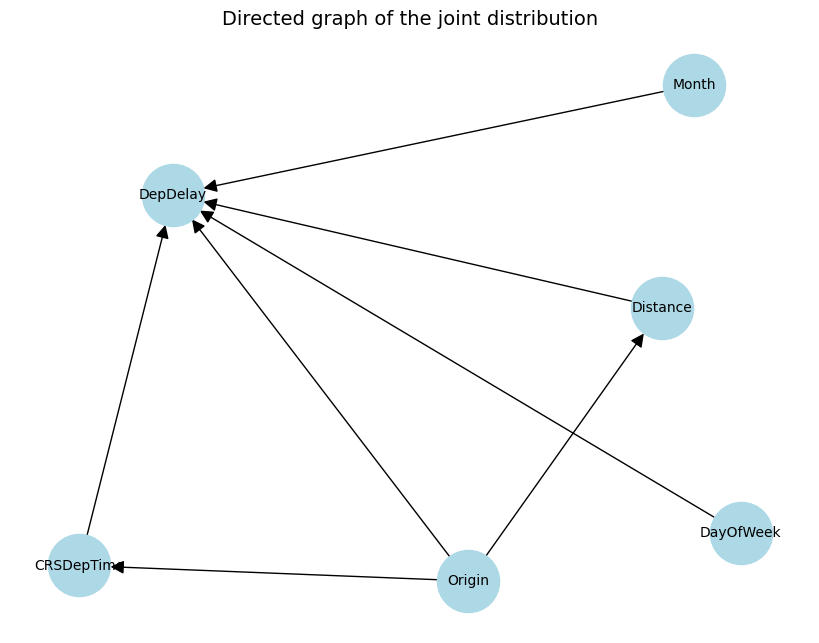

In [5]:

G = nx.DiGraph()


nodes = ["Month", "DayOfWeek", "Origin", "CRSDepTime", "Distance", "DepDelay"]
G.add_nodes_from(nodes)


edges = [
    ("Month", "DepDelay"),
    ("DayOfWeek", "DepDelay"),
    ("Origin", "CRSDepTime"),
    ("Origin", "Distance"),
    ("CRSDepTime", "DepDelay"),
    ("Distance", "DepDelay"),
    ("Origin", "DepDelay")
]
G.add_edges_from(edges)


plt.figure(figsize=(8, 6))
pos = nx.spring_layout(G, seed=42)
nx.draw(
    G, pos, with_labels=True, node_size=2000, node_color="lightblue",
    font_size=10, arrowsize=20, edge_color="black"
)
plt.title("Directed graph of the joint distribution", fontsize=14)
plt.show()

The Bayesian linear regression model is used to predict DepDelay based on the input features.

Graphical Model of the Inference:

The graphical model is a visual representation of the relationships between variables in a probabilistic model. In this case, the variables are the regression coefficients, the intercept and the observed outcome (y), which depends on the predictors (X_train).

The following relationships are in PyMC:

    Priors:prior distributions for the regression
    coefficients, intercept and the standard deviation of the residuals.
    These priors represent our beliefs about these parameters before seeing the data.
    
    Likelihood: The likelihood is modeled as a normal distribution,
    where the observed outcomes (y_train) are conditionally
    dependent on the predictors (X_train) through
    the linear relationship defined by the regression coefficients and intercept.

Parts of the graphical model are:

     coef: Regression coefficients, one per feature.
     intercept: The intercept term in the linear model
     weather: The latent weather variable affecting the departure delay
     X_train: The observed variables
     sigma: The standard deviation for the likelihood
     y: The observed variable (departure delay)

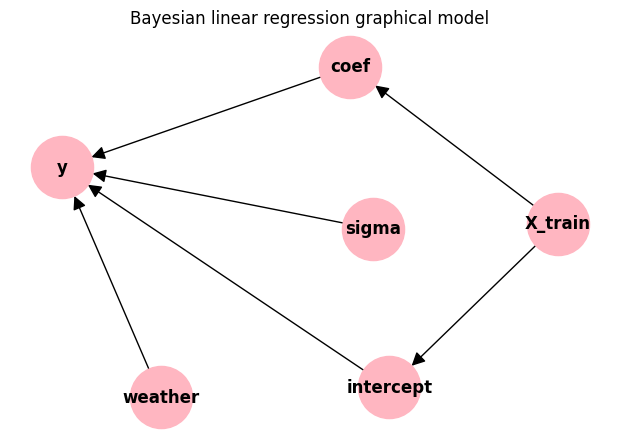

In [6]:

G = nx.DiGraph()

nodes = ['coef', 'intercept', 'weather', 'X_train', 'sigma', 'y']
G.add_nodes_from(nodes)

G.add_edges_from([
    ('X_train', 'coef'),
    ('X_train', 'intercept'),
    ('coef', 'y'),
    ('intercept', 'y'),
    ('weather', 'y'),
    ('sigma', 'y')
])



plt.figure(figsize=(6, 4))
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=True, node_size=2000, node_color='lightpink', font_size=12, font_weight='bold', arrowsize=20)
plt.title("Bayesian linear regression graphical model")
plt.show()



Output()

Output()

             mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
coef[0]     1.265  0.443   0.446    2.124      0.008    0.005    3338.0   
coef[1]     0.516  0.439  -0.326    1.315      0.006    0.005    5210.0   
coef[2]     3.694  0.429   2.890    4.475      0.006    0.004    5133.0   
coef[3]     3.604  0.440   2.813    4.446      0.006    0.004    4850.0   
coef[4]    -3.500  0.440  -4.331   -2.669      0.006    0.005    4825.0   
intercept  57.597  1.115  55.415   59.609      0.025    0.018    1982.0   
sigma      51.618  0.317  51.064   52.252      0.004    0.003    5177.0   
weather     0.578  1.017  -1.370    2.412      0.023    0.016    1988.0   

           ess_tail  r_hat  
coef[0]      2568.0    1.0  
coef[1]      3379.0    1.0  
coef[2]      3261.0    1.0  
coef[3]      3106.0    1.0  
coef[4]      2826.0    1.0  
intercept    2266.0    1.0  
sigma        3001.0    1.0  
weather      2175.0    1.0  


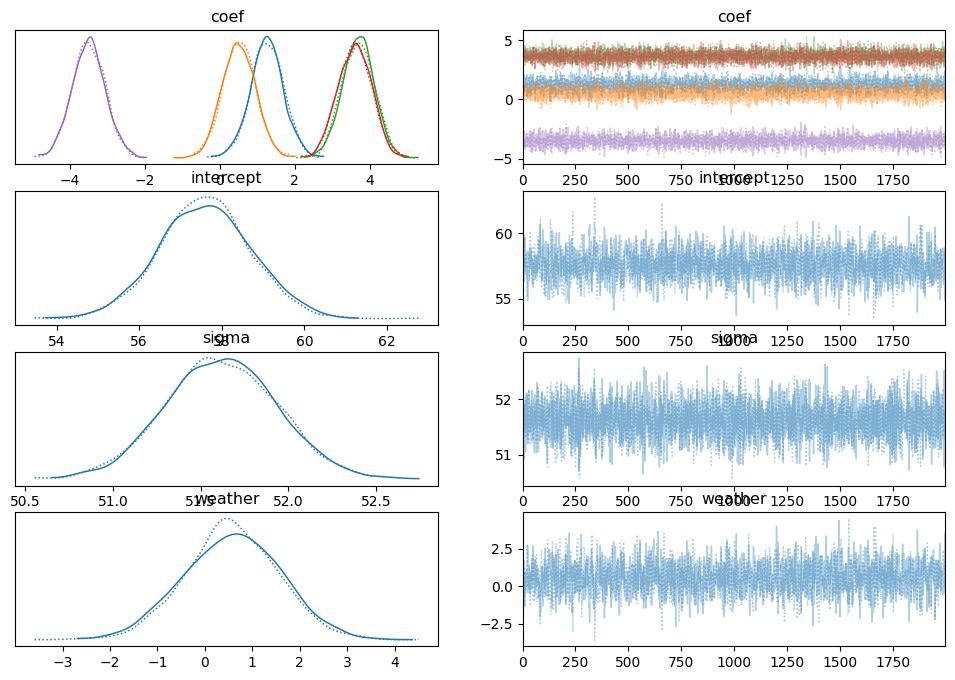

In [7]:
#Inferring the latent variable


X = filtered_df[["Month", "DayOfWeek", "Origin", "CRSDepTime", "Distance"]]
y = filtered_df['DepDelay']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


with pm.Model() as model:

    coef = pm.Normal('coef', mu=0, sigma=10, shape=X_train.shape[1])
    intercept = pm.Normal('intercept', mu=0, sigma=10)

    # Latent weather variable (unobserved feature)
    weather = pm.Normal('weather', mu=0, sigma=1)


    mu = pm.math.dot(X_train, coef) + intercept + weather

    sigma = pm.HalfNormal('sigma', sigma=10)
    likelihood = pm.Normal('y', mu=mu, sigma=sigma, observed=y_train)

    # Inference using MCMC
    trace = pm.sample(2000, return_inferencedata=True)

az.plot_trace(trace)
print(az.summary(trace))

#Experiment

#Discussion and conclusion


Discussion:

I used bayesian linear regression model to predict flight departure delays using predictors like Month, DayOfWeek, Origin, CRSDepTime, and Distance. I defined normal priors for coefficients and intercept, with half-normal prior for the noise. As a posterior inference MCMC sampling was used and it provided posterior distributions for coefficients, intercept, and noise.

Conclusion:

 Bayesian regression offers predictions with uncertainty, making it useful for real-world applications like flight delay forecasting. Coefficients show how each feature  influences delays.A positive value means that an increase in the predictor variable will increase DepDelay and a negative value means the predictor variable will decrease DepDelay.
    
    Coef[0]=month : Month has a positive effect on DepDelay
    Coef[1]=DayOfWeek : DayOfWeek has a positive effect on DepDelay
    Coef[2]=Origin : Origin has a strong positive effect on DepDelay
    Coef[3]=CRSDepTime : CRSDepTime has a positive effect on DepDelay
    Coef[4]=Distance : Distance has a negative effect on DepDelay.

    The latent weather variable has a mean value of 0.596
    meaning that weather has a small positive effect on departure delay.
    The 95% HPDI telss that the true value of
    the weather's effect could range from negative (worsening delays)
    to positive (improving delays)

